<a href="https://colab.research.google.com/github/CPeti/Spot-price-prediction/blob/peter-dev/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [267]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import periodogram, find_peaks, detrend

In [2]:
# import data from csv
data = pd.read_csv('./data/data_NO2.csv', sep=';')
data.head()

,datetime_utc,volume_demand,volume_production,spot_price
0,2015-12-31 23:00:00+00:00,4043.0,7818.0,16.39
1,2016-01-01 00:00:00+00:00,4010.0,7694.0,16.04
2,2016-01-01 01:00:00+00:00,3930.0,7437.0,15.74
3,2016-01-01 02:00:00+00:00,3839.0,7120.0,15.57
4,2016-01-01 03:00:00+00:00,3833.0,7041.0,15.47


In [3]:
# count the number of missing values in each column
missing_values = data.isnull().sum()
missing_values

datetime_utc         0
volume_demand        0
volume_production    0
spot_price           0
dtype: int64

In [16]:
# add calendar features
data['date'] = pd.to_datetime(data['datetime_utc'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['dayofweek'] = data['date'].dt.dayofweek

In [5]:
# additional time features
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if x > 4 else 0)
data['working_hours'] = data['hour'].apply(lambda x: 1 if 8 <= x <= 17 else 0)
data['night'] = data['hour'].apply(lambda x: 1 if 0 <= x <= 6 else 0)
data['morning'] = data['hour'].apply(lambda x: 1 if 7 <= x <= 11 else 0)
data['afternoon'] = data['hour'].apply(lambda x: 1 if 12 <= x <= 16 else 0)
data['evening'] = data['hour'].apply(lambda x: 1 if 17 <= x <= 23 else 0)


In [6]:
# production and demand features
data['delta'] = data['volume_production'] - data['volume_demand']

# create a feature where we sum the previous days production values
data['volume_production_rolling'] = data['volume_production'].rolling(window=48).sum()
data['volume_demand_rolling'] = data['volume_demand'].rolling(window=48).sum()




In [7]:
# shift spot_price by 24 hours as target
data['target'] = data['spot_price'].shift(-24)

In [12]:
# check correlation between features and target
# drop datetime_utc
data_ = data.drop(columns=['datetime_utc', 'date', 'spot_price'])
correlation = data_.corr()
correlation['target'].sort_values(ascending=False)

target                       1.000000
year                         0.666659
volume_production            0.101399
volume_demand                0.099505
working_hours                0.094767
delta                        0.087912
month                        0.081791
morning                      0.079679
hour                         0.046832
afternoon                    0.039247
volume_demand_rolling        0.031718
volume_production_rolling   -0.002349
evening                     -0.006977
day                         -0.007680
weekend                     -0.041984
dayofweek                   -0.054476
night                       -0.099276
Name: target, dtype: float64

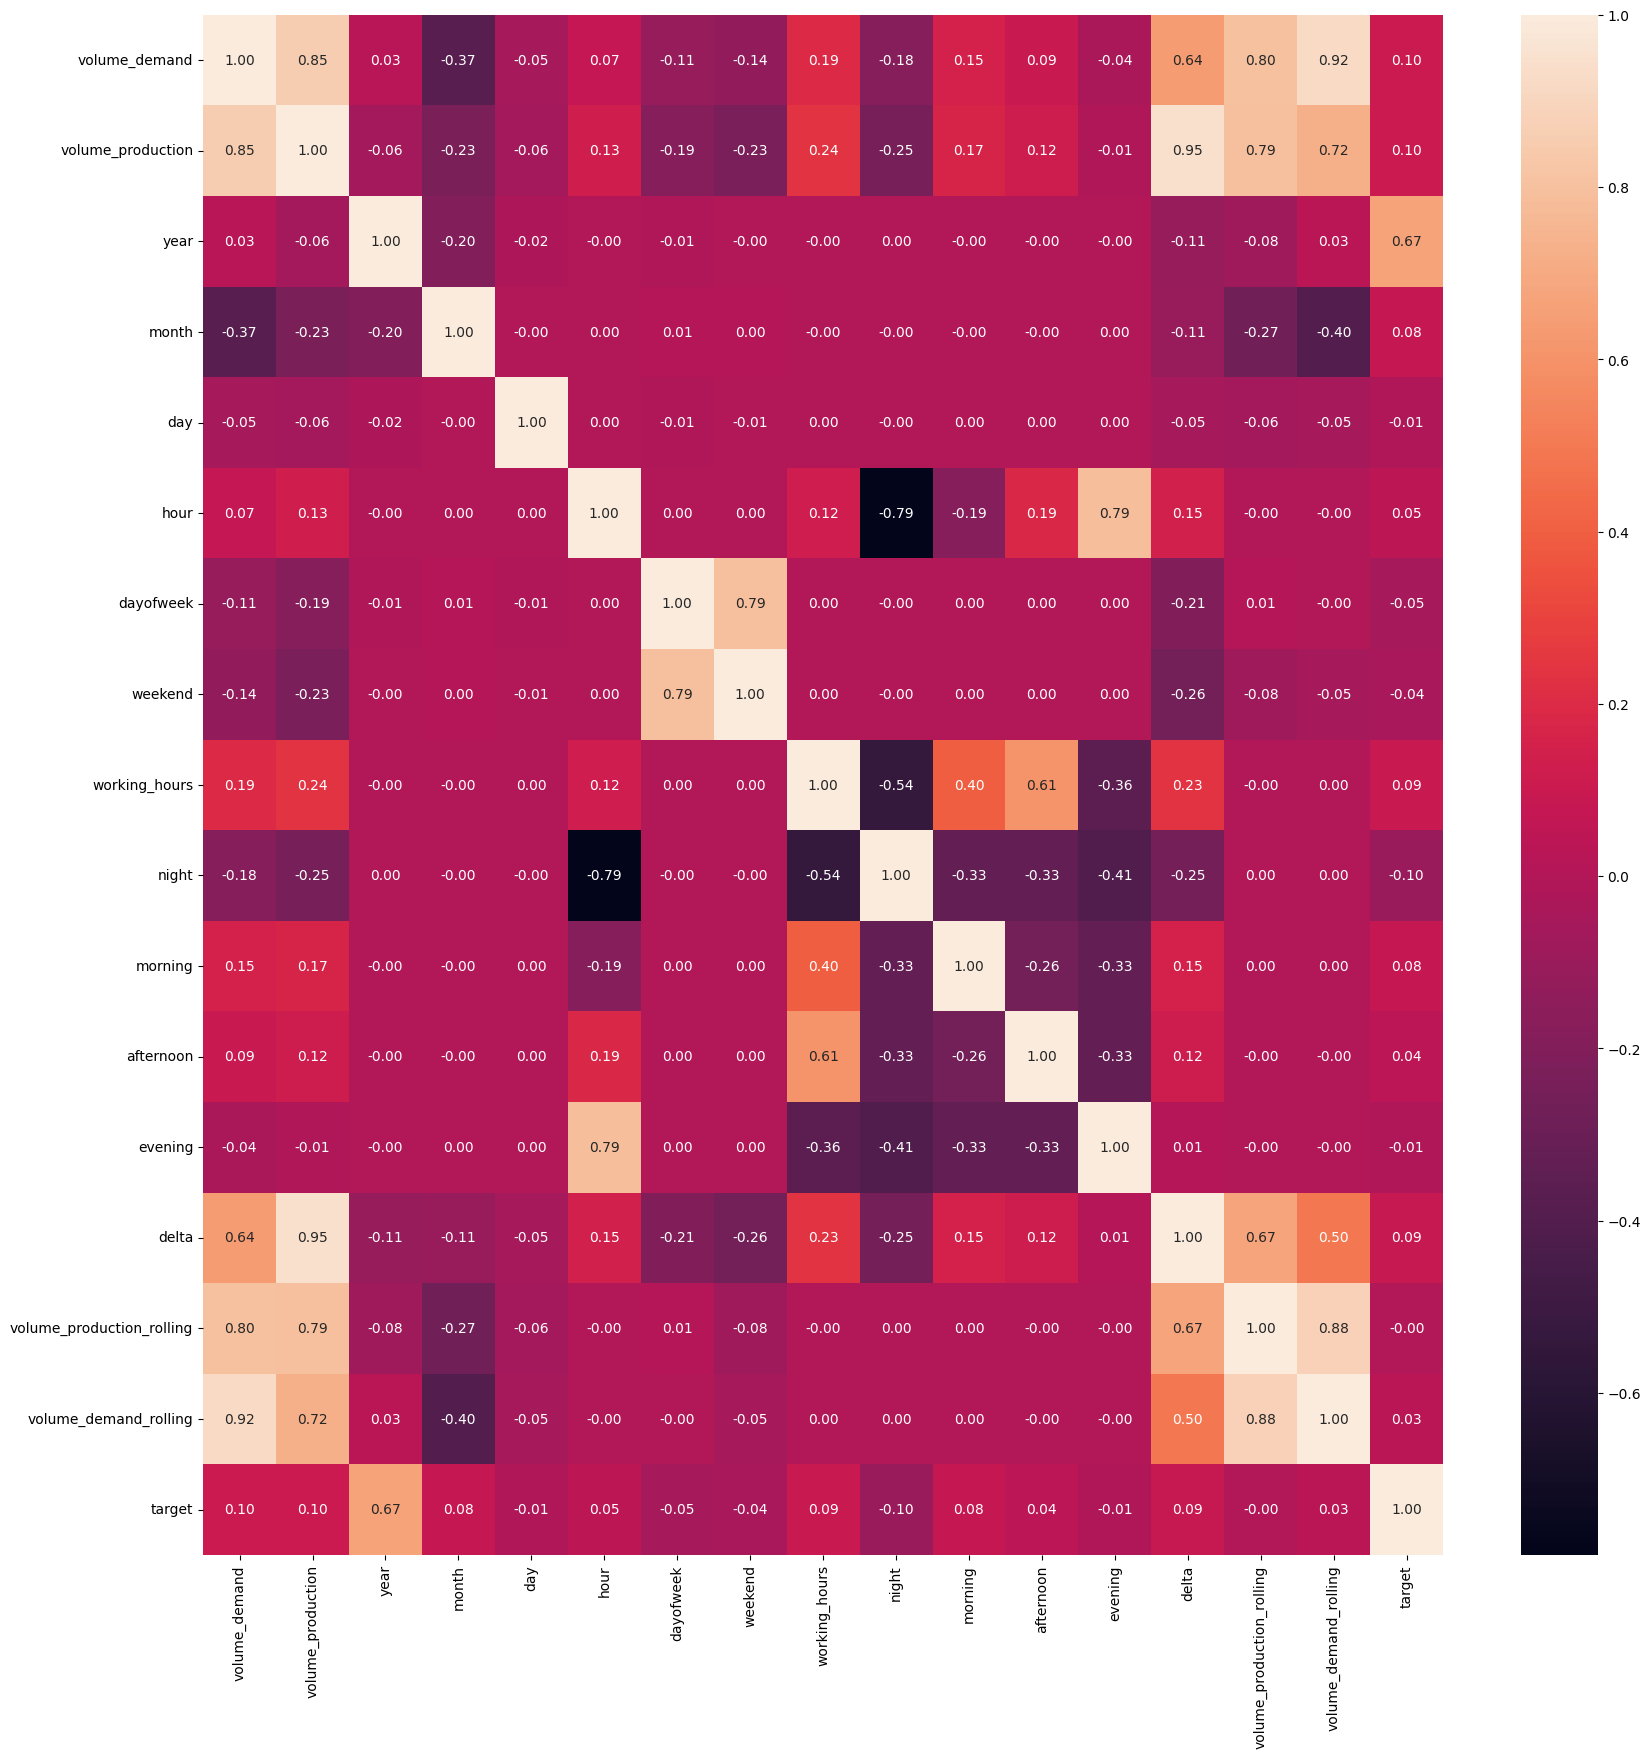

In [14]:
# correlation heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, annot=True, fmt=".2f")
plt.show()


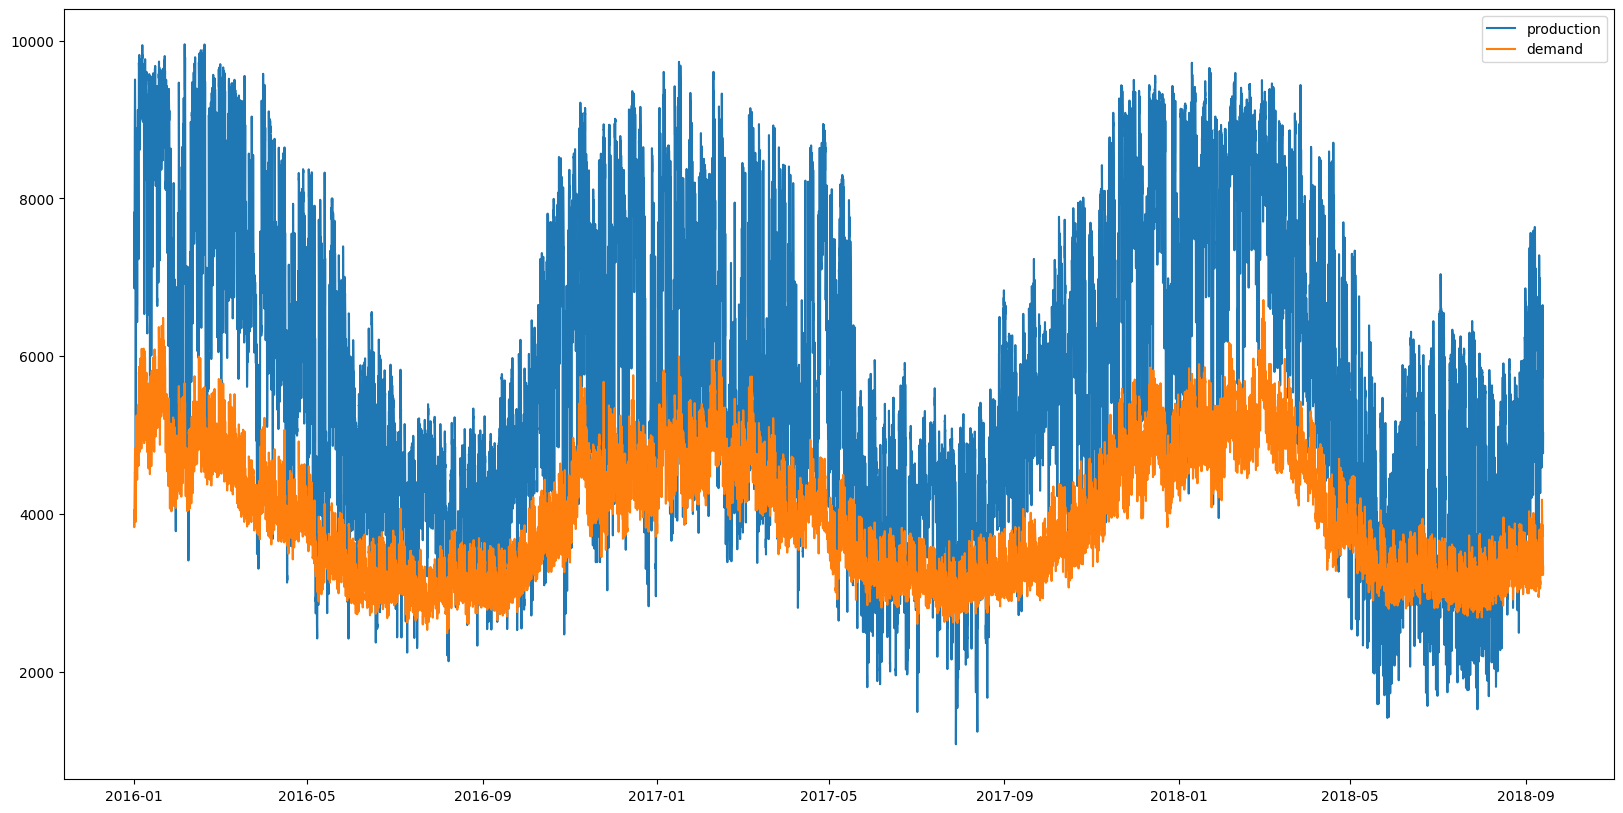

In [44]:
# plot production and demand
plt.figure(figsize=(20, 10))
plt.plot(data['date'], data['volume_production'], label='production')
plt.plot(data['date'], data['volume_demand'], label='demand')
# plot one year
#plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-12-31'))
plt.legend()

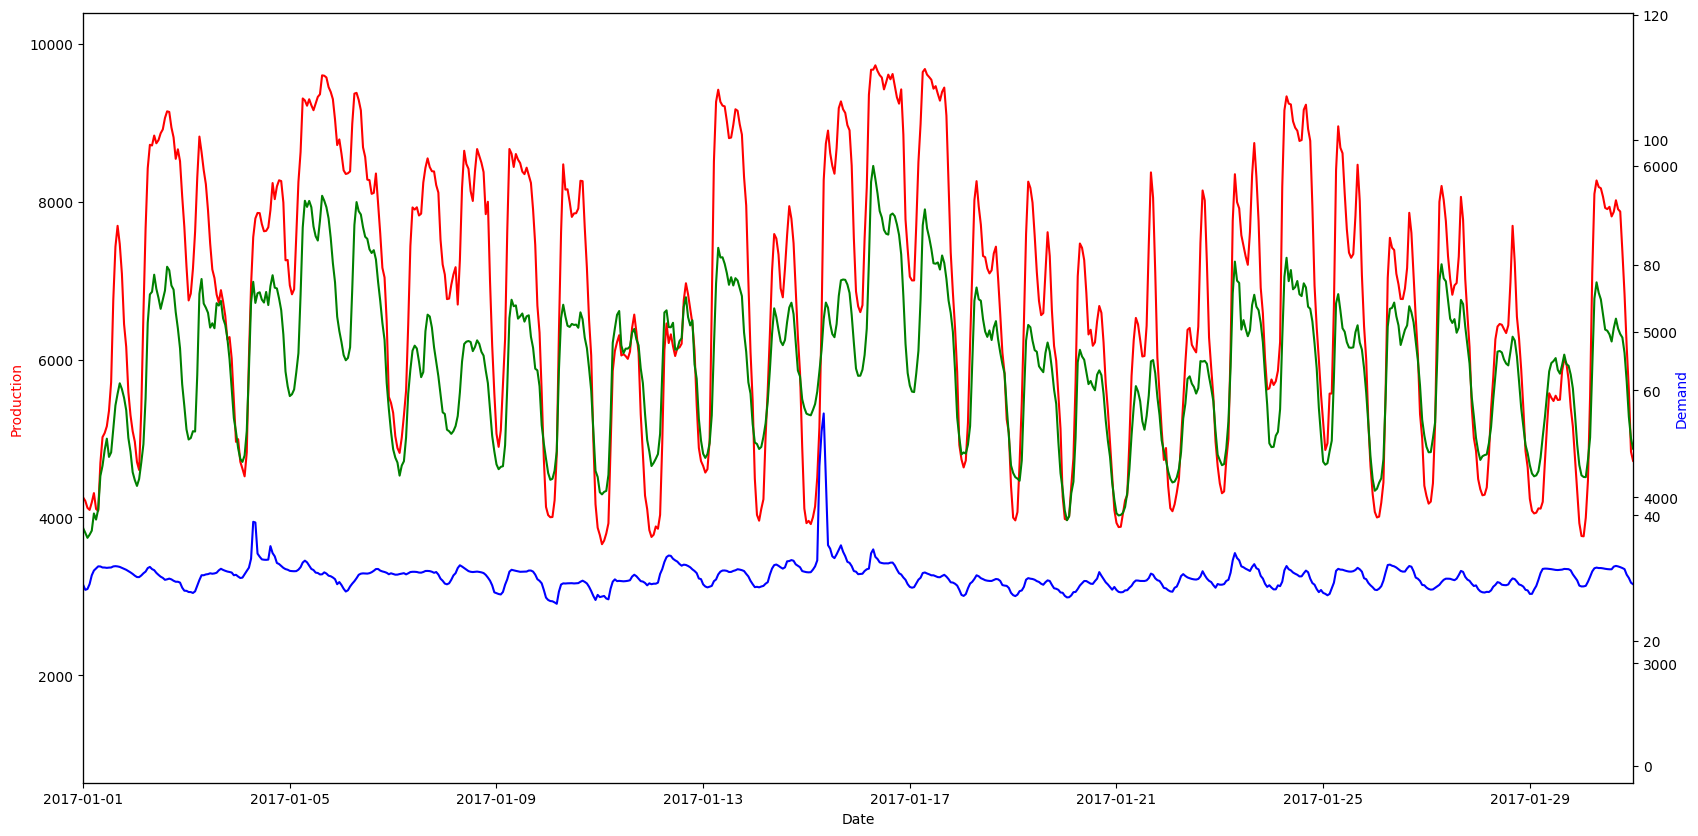

In [42]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.plot(data['date'], data['volume_production'], 'r-')
ax2.plot(data['date'], data['target'], 'b-')
ax3.plot(data['date'], data['volume_demand'], 'g-')
ax1.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-31'))
ax2.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-31'))
ax3.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-31'))

ax1.set_xlabel('Date')
ax1.set_ylabel('Production', color='r')
ax2.set_ylabel('Demand', color='b')

plt.show()

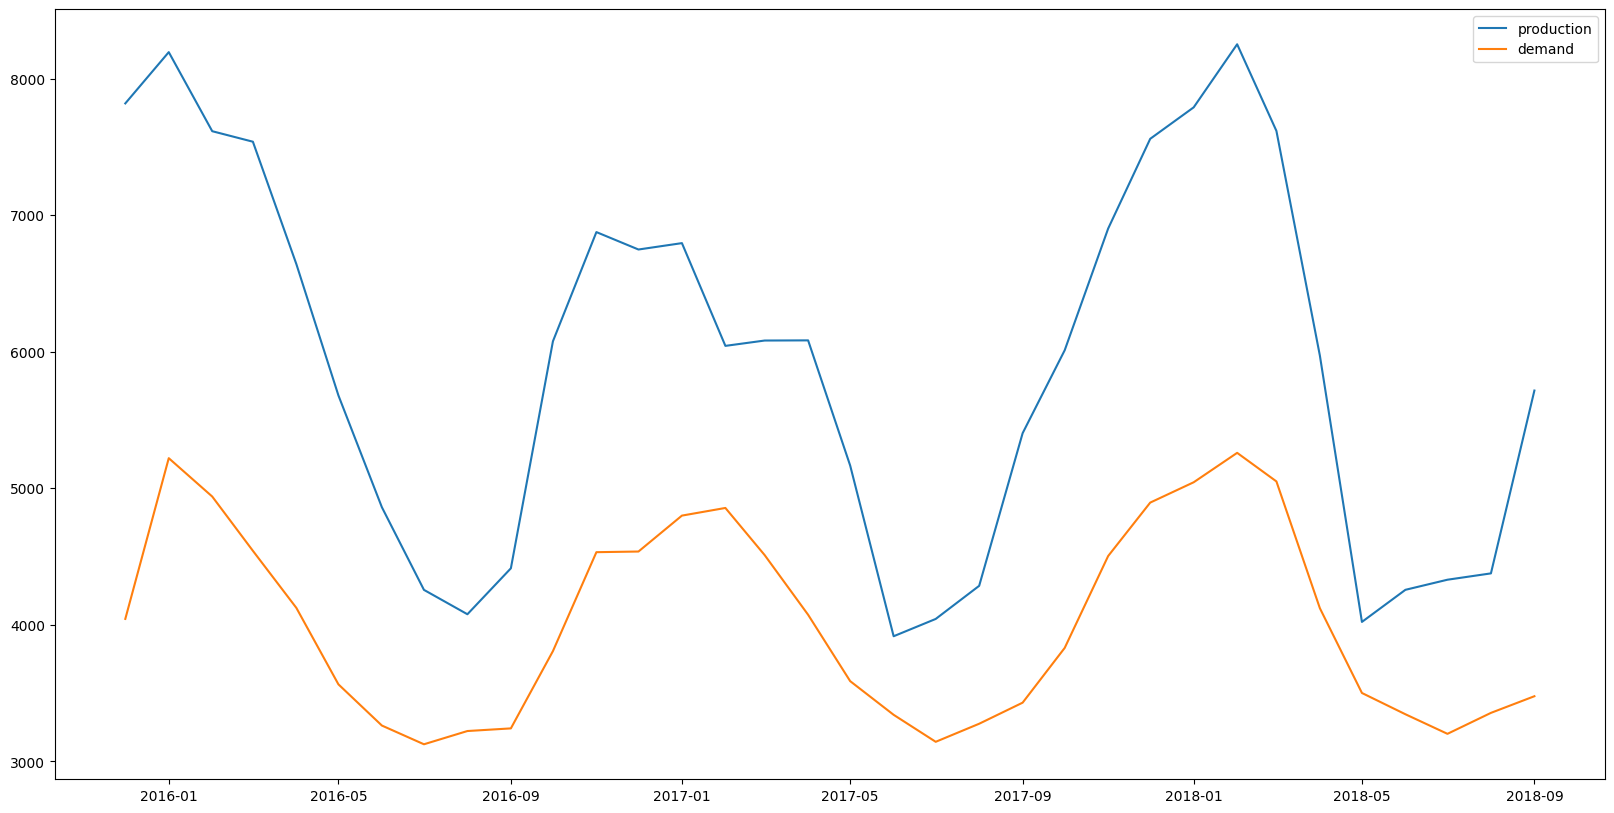

In [11]:
# calculate production and demand monthly averages
monthly = data.groupby(['year', 'month']).agg({'volume_production': 'mean', 'volume_demand': 'mean'}).reset_index()
monthly['date'] = pd.to_datetime(monthly[['year', 'month']].assign(day=1))
# plot production and demand monthly
plt.figure(figsize=(20, 10))
plt.plot(monthly['date'], monthly['volume_production'], label='production')
plt.plot(monthly['date'], monthly['volume_demand'], label='demand')
plt.legend()




In [273]:
f

array([ 0.00000000e+00,  8.45094228e-05,  1.69018846e-04, ...,
       -2.53528268e-04, -1.69018846e-04, -8.45094228e-05])

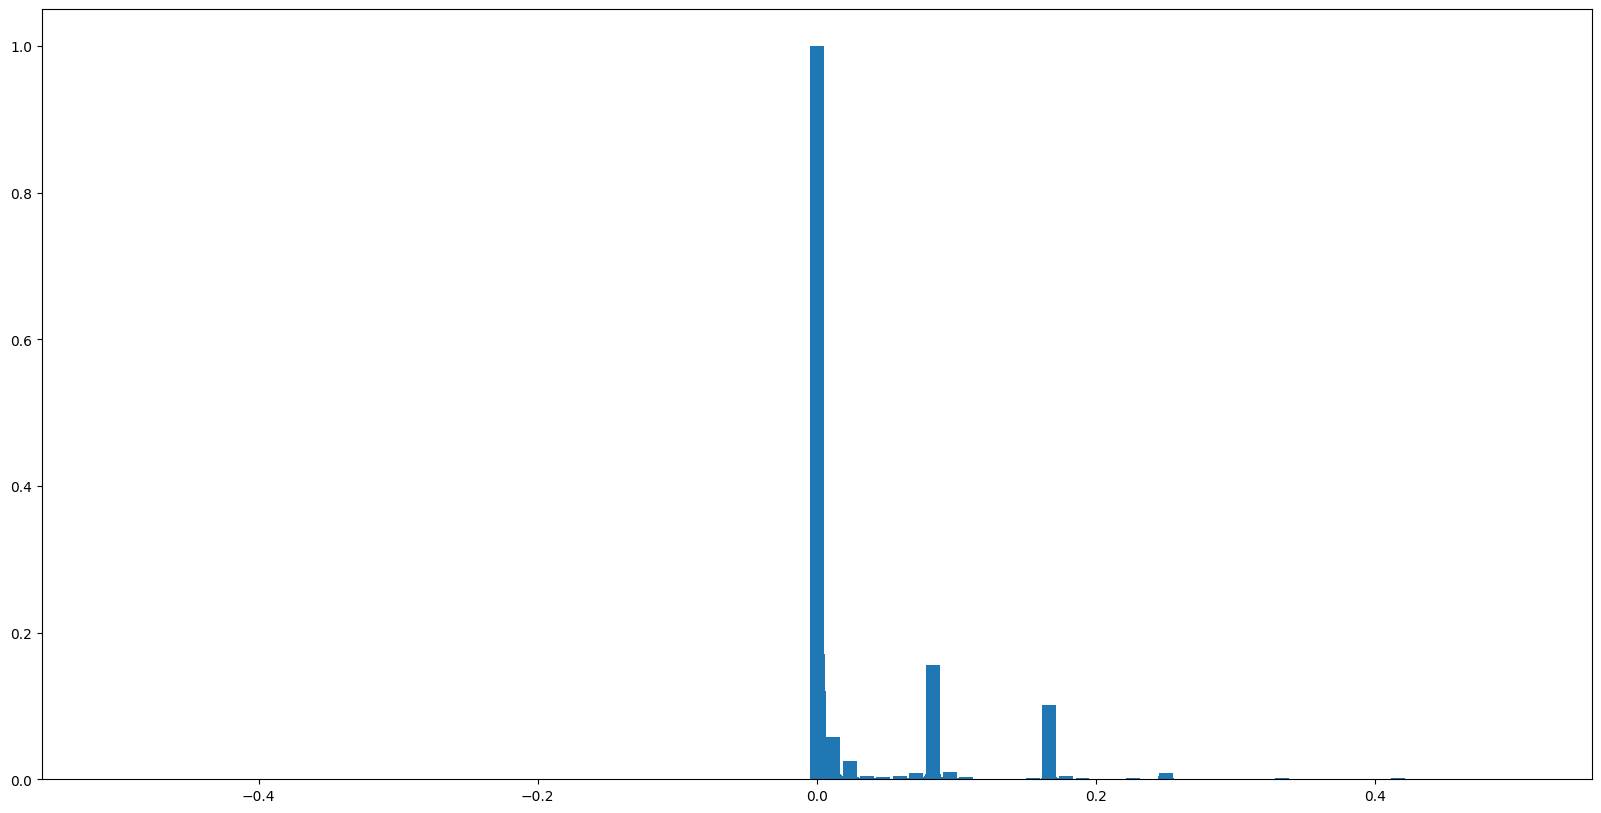

In [365]:
prices = data['spot_price']
prices = prices - prices.mean()
prices = detrend(prices)
prices = np.pad(prices, (0, 2 ** 16 - prices.shape[0]), 'constant')

sample_size = prices.shape[0]

FF = np.abs(np.fft.fft(prices) / sample_size) ** 2
P = (4 / sample_size) * FF[0:sample_size // 2]
f = np.fft.fftfreq(sample_size//2, 1)
P = P[1:] / P[1:].max()
peaks, _ = find_peaks(P, prominence=(0.004, 20.6), distance=20)


plt.figure(figsize=(20, 10))
plt.bar(f[1:], P, width=0.01)
plt.show()

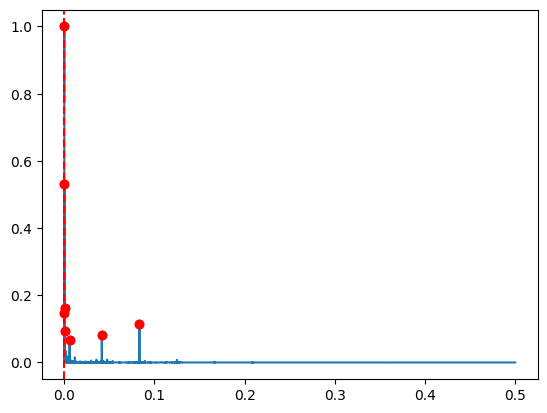

In [309]:
# create a periodogram
detrended_prices = detrend(data['spot_price'])
padded_prices = np.pad(detrended_prices, (0, 2000), 'constant')
f, Pxx = periodogram(padded_prices, fs=1, detrend=False)
periods = f[1:]
density = Pxx[1:] / Pxx[1:].max()
max_density_index = density.argmax()

period = periods[max_density_index]
peaks, _ = find_peaks(density, prominence=0.05)

plt.plot(periods, density)
plt.plot(periods[peaks], density[peaks], 'ro')
plt.plot(periods[peaks], density[peaks], 'ro')
plt.axvline(period, color='red', linestyle='--')
plt.show()



In [368]:
# create a list of (period, density) tuples for the peaks
peaks_tuple = [(np.round(1/periods[i])/24, density[peak]) for peak, i in enumerate(peaks)]
peaks_tuple.sort(key=lambda x: x[1], reverse=True)
peaks_tuple

[(38.208333333333336, 1.0),
 (267.3333333333333, 0.7774694054185496),
 (6.5, 0.5304679174543506),
 (3.375, 0.16253034991073384),
 (10.166666666666666, 0.1469222179360586),
 (5.25, 0.13075216897880967),
 (12.583333333333334, 0.10294542698292289),
 (0.375, 0.09436596668280582),
 (17.833333333333332, 0.08541496292829455),
 (4.666666666666667, 0.0782009273232911),
 (8.166666666666666, 0.060250735088599704),
 (0.4166666666666667, 0.05717847657431415),
 (1.4583333333333333, 0.05320116078107118),
 (2.75, 0.0444620659657663),
 (0.9166666666666666, 0.04278452042443743),
 (0.3333333333333333, 0.032076804352933766),
 (0.4583333333333333, 0.03139955626924559),
 (0.20833333333333334, 0.03139554648051073),
 (4.041666666666667, 0.024201422578166792),
 (0.16666666666666666, 0.02193851199589634),
 (1.375, 0.016545704209887185),
 (2.5416666666666665, 0.013745055877996846),
 (2.9166666666666665, 0.008332782238642342),
 (0.5416666666666666, 0.005837140590897624),
 (2.0833333333333335, 0.005835500944979268

In [254]:
peak_periods = 1 / periods[peaks]
tolerance = 0.1
whole_hour_periods = peak_periods[np.abs(peak_periods - np.round(peak_periods)) < tolerance]

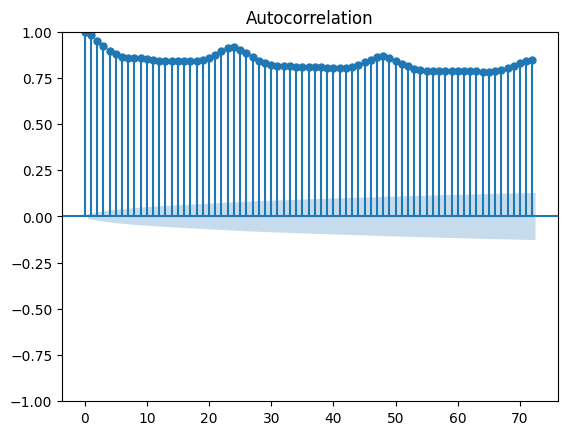

In [369]:
# create correlogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['spot_price'], lags=72)
plt.show()


ADF Statistic: -4.008970
p-value: 0.001364
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


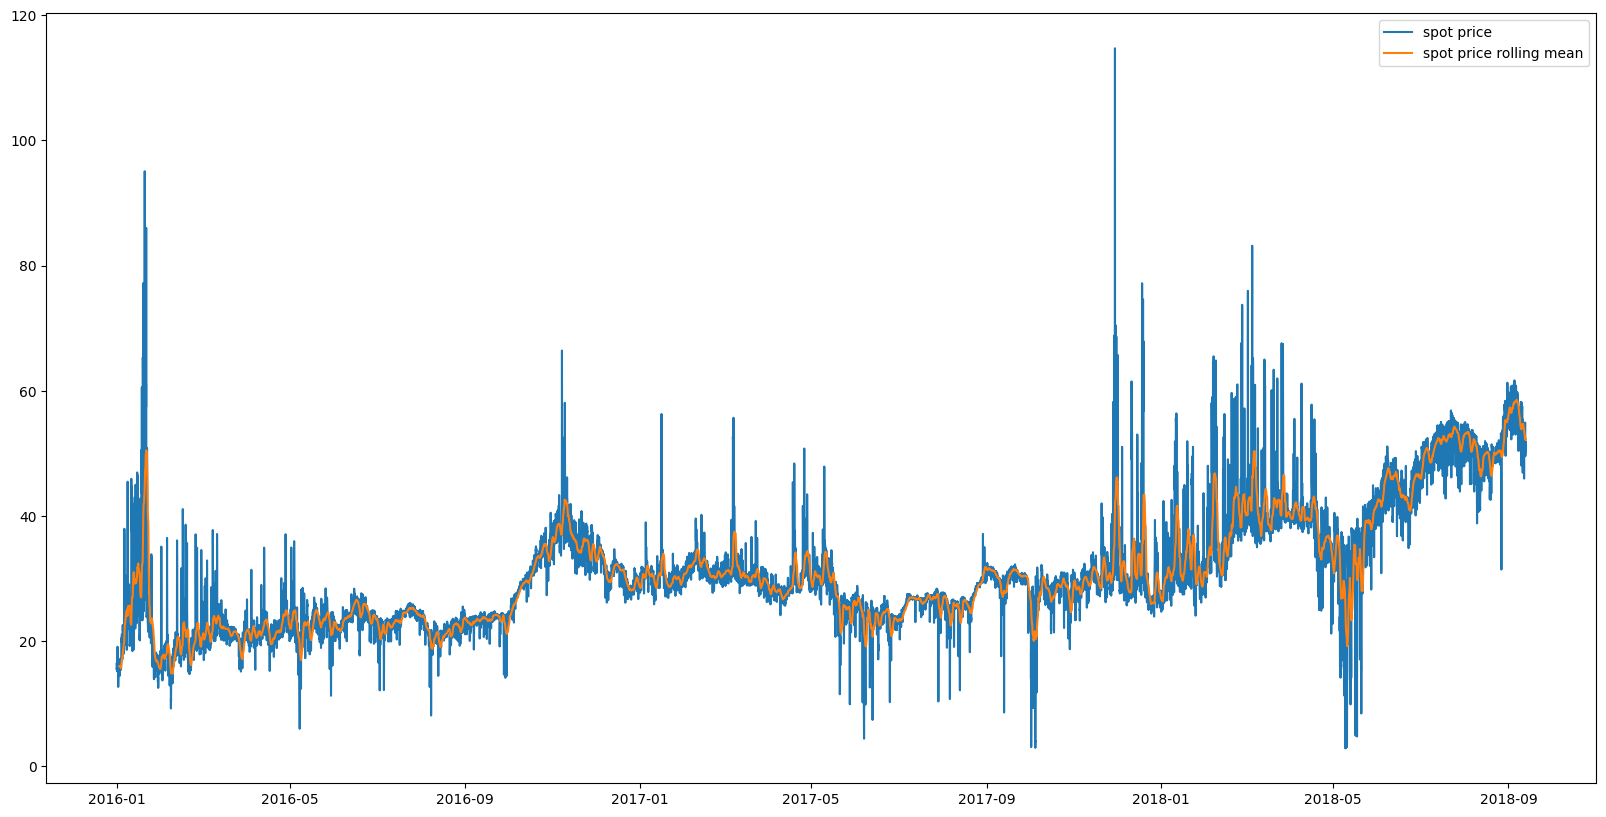

In [119]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['spot_price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# create a rolling mean and rolling standard deviation
data['spot_price_rolling'] = data['spot_price'].rolling(window=48).mean()
data['spot_price_std'] = data['spot_price'].rolling(window=48).std()

# plot spot price and rolling mean
plt.figure(figsize=(20, 10))
plt.plot(data['date'], data['spot_price'], label='spot price')
plt.plot(data['date'], data['spot_price_rolling'], label='spot price rolling mean')
plt.legend()




Text(0, 0.5, 'Demand')

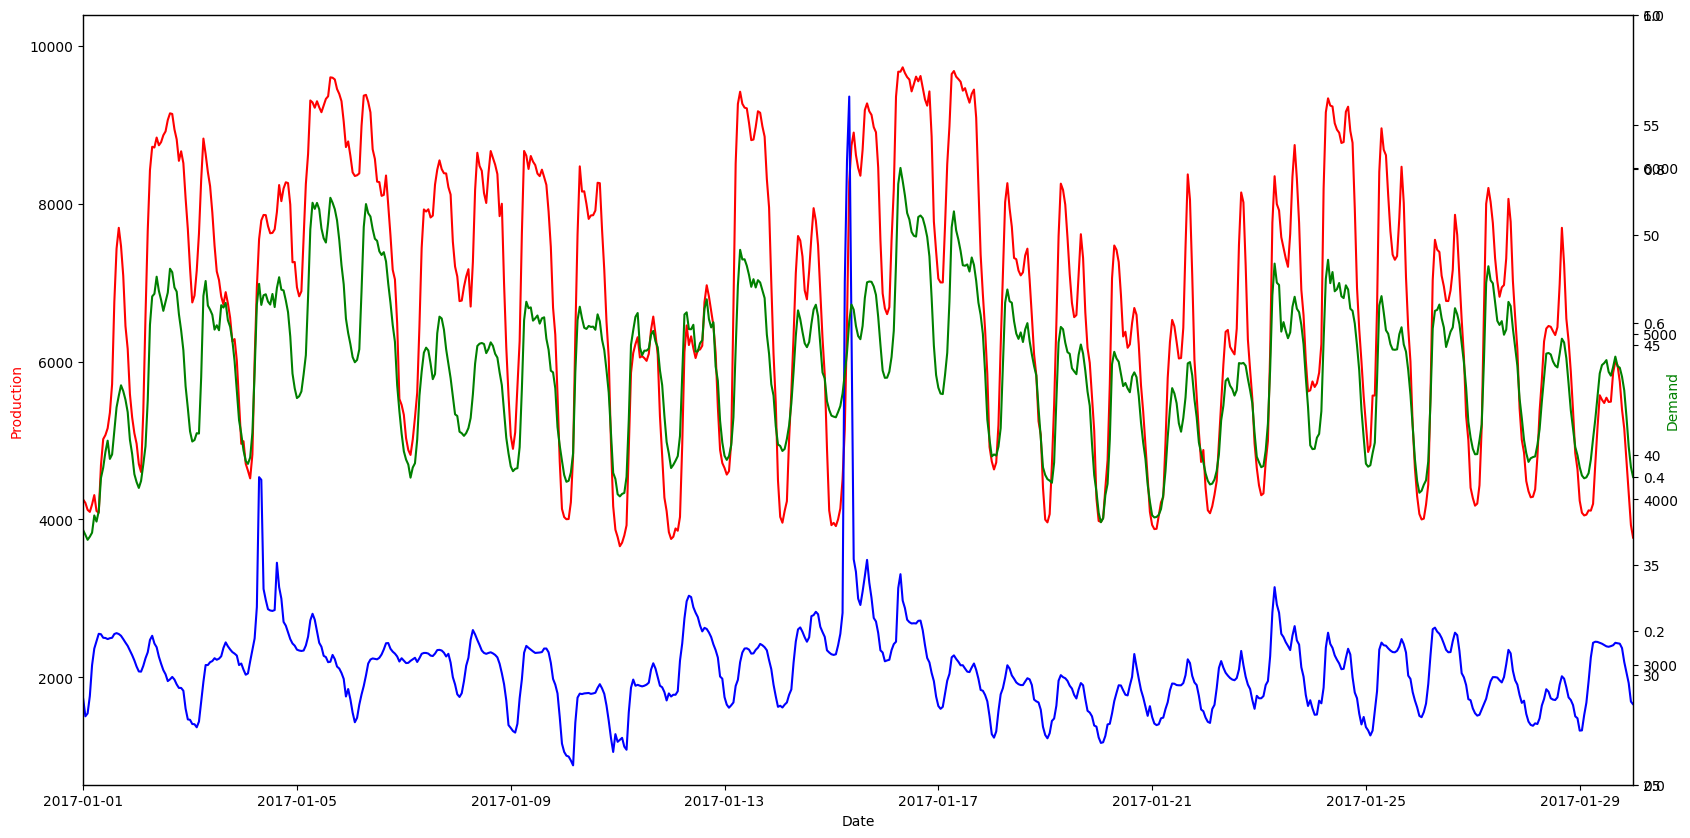

In [396]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()

ax1.plot(data['date'], data['volume_production'], 'r-')
ax2.plot(data['date'], data['target'], 'b-')
ax3.plot(data['date'], data['volume_demand'], 'g-')
# plot delta

ax1.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-30'))
ax2.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-30'))
ax2.set_ylim(25, 60)
ax1.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-30'))

ax1.set_xlabel('Date')
ax1.set_ylabel('Production', color='r')
ax2.set_ylabel('Demand', color='g')


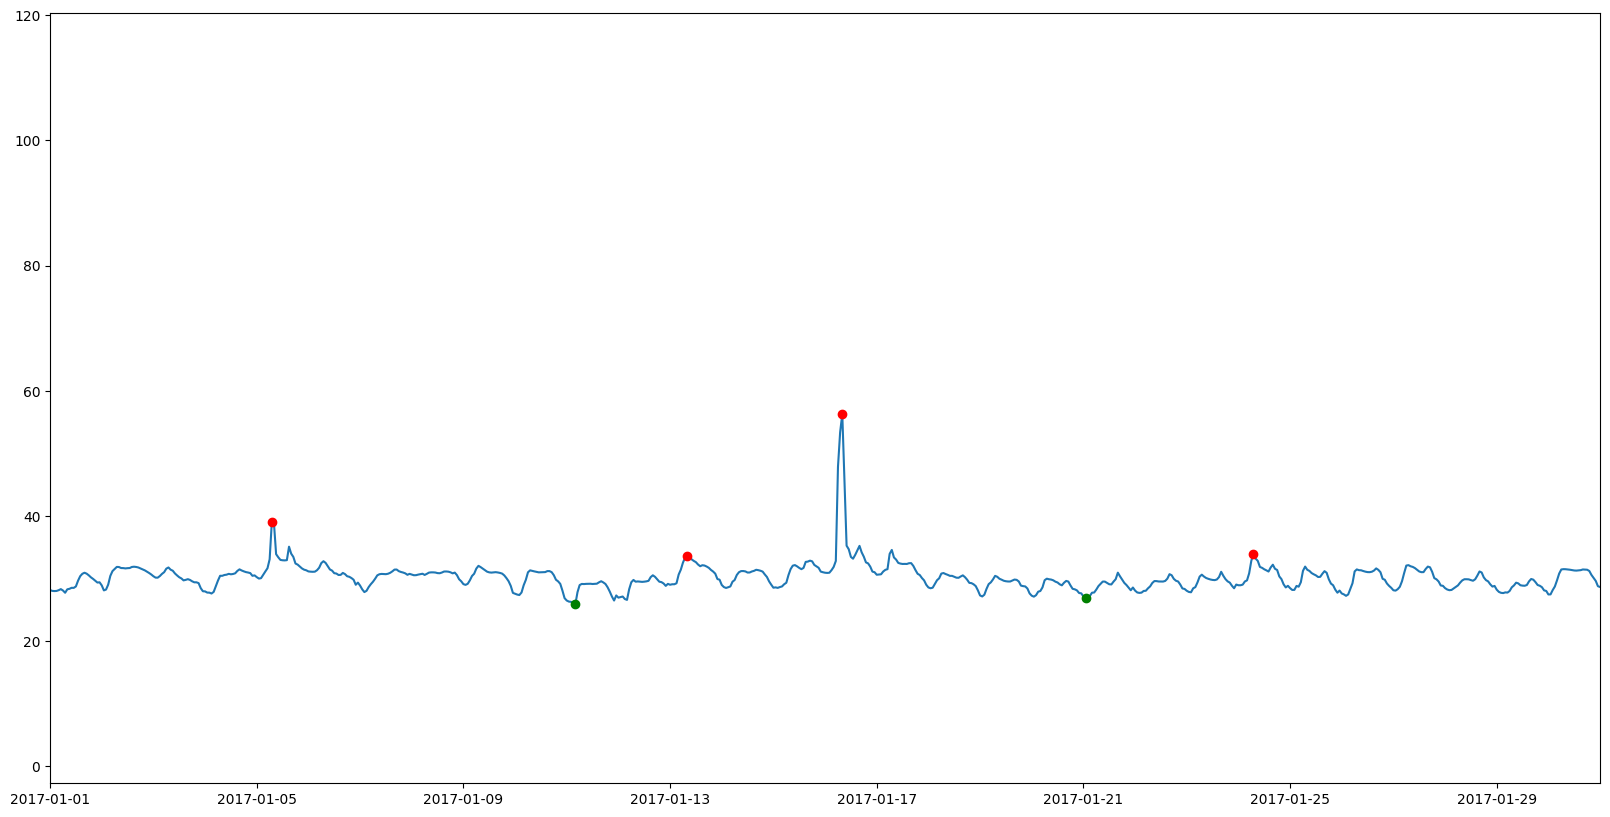

In [393]:
# plot one month of spot prices
plt.figure(figsize=(20, 10))
plt.plot(data['date'], data['spot_price'])
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-31'))

#find peaks
peaks, _ = find_peaks(data['spot_price'], prominence=5)
# find low points
valleys, _ = find_peaks(-data['spot_price'], prominence=10)
plt.plot(data['date'][peaks], data['spot_price'][peaks], 'ro')
plt.plot(data['date'][valleys], data['spot_price'][valleys], 'go')
plt.show()
